In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_excel('tim_data/tim_all_cofactors.xlsx')
data = data.assign(Done=[False for i in range(len(data))])
data.head()

,name,element_id,ecocyc_id,plot_id,count,parent,done,Done
0,FE,FE,NaN,10001.0,483709.0,-1,0.0,False
1,Electron Transfer Chains,FE,Electron-Transfer,10104.0,116919.0,10001,0.0,False
2,Amino Acid Biosynthesis,FE,Amino-Acid-Biosynthesis,10109.0,38957.0,10001,0.0,False
3,TCA Cycle,FE,TCA-VARIANTS,10103.0,35260.0,10001,0.0,False
4,Regulation of Transcription,FE,Regulation of transcription,10113.0,33935.0,10001,0.0,False


### Sunburst with the small slices aggregated in "Remaining" (Deprecated)

In [3]:
def sunburst_remaining(nodes, total=np.pi * 2, offset=0, level=0, ax=None, defined_color=None):
    ax = ax or plt.subplot(111, projection='polar')

    if level == 0 and len(nodes) == 1:
        label, value, subnodes = nodes[0]
        ax.bar([0], [0.5], [np.pi * 2])
        ax.text(0, 0, label, ha='center', va='center')
        sunburst_remaining(subnodes, total=value, level=level + 1, ax=ax)
    elif nodes:
        d = np.pi * 2 / total
        labels, widths, colors = [], [], []
        local_offset = offset
        color_index = 0
        remaining_value = 0
        non_negligible_nodes_length = 0
        for label, value, subnodes in nodes:
            if value * d >= 0.1: 
                non_negligible_nodes_length += 1
                labels.append(label)
                widths.append(value * d)
                if label == '':
                    colors.append('black')
                elif level == 1:
                    colors.append(set2[color_index])
                    sunburst_remaining(subnodes, total=total, offset=local_offset, level=level + 1, ax=ax, defined_color=color_index)
                else:
                    if color_index % 2 == 0:
                        colors.append(pastel_set2[defined_color])
                    else:
                        colors.append(set2[defined_color])
                    sunburst_remaining(subnodes, total=total, offset=local_offset, level=level + 1, ax=ax, defined_color=defined_color)
                color_index += 1
                local_offset += value
            else:
                remaining_value += value
        
        if remaining_value > 0:
            labels.append('Remaining')
            widths.append(remaining_value * d)
            
            if level == 1:
                colors.append(set2[color_index])
                sunburst_remaining(subnodes, total=total, offset=local_offset, level=level + 1, ax=ax, defined_color=color_index)
            else:
                if color_index % 2 == 0:
                    colors.append(pastel_set2[defined_color])
                else:
                    colors.append(set2[defined_color])
                sunburst_remaining(subnodes, total=total, offset=local_offset, level=level + 1, ax=ax, defined_color=defined_color)
            color_index += 1
            local_offset += remaining_value
        
        values = np.cumsum([offset * d] + widths[:-1])
        heights = [1] * (non_negligible_nodes_length + 1)
        bottoms = np.zeros(non_negligible_nodes_length + 1) + level - 0.5
        rects = ax.bar(values, heights, widths, bottoms, linewidth=1,
                       edgecolor='white', align='edge', color=colors)
        for rect, label in zip(rects, labels):
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            rotation = (90 + (360 - np.degrees(x) % 180)) % 360
            ax.text(x, y, label, rotation=rotation, ha='center', va='center') 

    if level == 0:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_axis_off()
        
        plt.savefig('tim_data/all_sunburst.png', bbox_inches='tight')

### Sunburst with the small slices not aggregated


In [40]:
def sunburst(nodes, total=np.pi * 2, offset=0, level=0, ax=None, defined_color=None):
    ax = ax or plt.subplot(111, projection='polar')

    if level == 0 and len(nodes) == 1:
        label, value, subnodes = nodes[0]
        ax.bar([0], [0.5], [np.pi * 2])
        ax.text(0, 0, label, ha='center', va='center')
        sunburst(subnodes, total=value, level=level + 1, ax=ax)
    elif nodes:
        d = np.pi * 2 / total
        labels, widths, colors = [], [], []
        local_offset = offset
        color_index = 0
        for label, value, subnodes in nodes:
            if level == 2 and value * d >= 0.06: 
                labels.append(label)
            elif level == 3 and value * d >= 0.03:
                try:
                    labels.append(gene_from_protein(label)[0])
                except:
                    labels.append(label)
            widths.append(value * d)
            if label == '':
                colors.append('black')
            elif level == 1:
                colors.append(set2[color_index])
                sunburst(subnodes, total=total, offset=local_offset, level=level + 1, ax=ax, defined_color=color_index)
            else:
                if color_index % 2 == 0:
                    colors.append(pastel_set2[defined_color])
                else:
                    colors.append(set2[defined_color])
                sunburst(subnodes, total=total, offset=local_offset, level=level + 1, ax=ax, defined_color=defined_color)
            color_index += 1
            local_offset += value
        
        values = np.cumsum([offset * d] + widths[:-1])
        heights = [1] * len(nodes)
        bottoms = np.zeros(len(nodes)) + level - 0.5
        rects = ax.bar(values, heights, widths, bottoms, linewidth=1,
                       edgecolor='black', align='edge', color=colors)
        for rect, label in zip(rects, labels):
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            rotation = (90 + (360 - np.degrees(x) % 180)) % 360
            ax.text(x, y, label, rotation=rotation, ha='center', va='center') 

    if level == 0:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_axis_off()
        
        plt.savefig('tim_data/all_sunburst.png', bbox_inches='tight')

In [5]:
parent_layer_sums = {}
parent_list = data['parent'].unique().tolist()
# layer_list = data['Layer'].unique().tolist()
# max_layer = max(layer_list)

for parent in parent_list:
#    for layer in layer_list:
    cur_sum = 0
    for index, row in data.iterrows():
        if row['parent'] == parent: #and index != len(data) - 1:
            cur_sum += row['count']
    parent_layer_sums[parent] = cur_sum

### Version that uses percentages (deprecated)

In [6]:
def transform_data_percent(df, data_tuple, parent_name, parent_value, cur_layer):
    df['Done'] = df['Done'].astype(bool)
    children = df[(df['Layer'] == cur_layer) & (df['Parent'] == parent_name) & (df['Done'] == False)]
    print(children)
    for _, child in children.iterrows():
        child_value = 0
        if parent_layer_sums[(parent_name, cur_layer)] != 0:
            child_value = child['Count'] / parent_layer_sums[(parent_name, cur_layer)] * parent_value
        child_tuple = (child['Name'], child_value, [])
        data_tuple[2].append(child_tuple)
        df.at[child.name, 'Done'] = True  # Mark as done
        transform_data_percent(df, child_tuple, child['Name'], child_value, cur_layer + 1)

## Version that uses actual count values


In [7]:
# def layer_fill(df, data_tuple, cur_layer, parent_value):
#     child_tuple = ('', parent_value, [])
#     data_tuple[2].append(child_tuple)  
#     if cur_layer != max_layer:
#         layer_fill(df, child_tuple, cur_layer + 1, parent_value)

def transform_data_count(df, data_tuple, parent_id, parent_value):
    df['done'] = df['done'].astype(bool)
    children = df[(df['parent'] == parent_id) & (df['done'] == False)]
    layer_sum = 0
    for _, child in children.iterrows():
        child_value = child['count']
        layer_sum += child_value
        child_tuple = (child['name'], child_value, [])
        data_tuple[2].append(child_tuple)
        df.at[child.name, 'Done'] = True  # Mark as done
        transform_data_count(df, child_tuple, child['plot_id'], child_value)

    if layer_sum != parent_value and len(data_tuple[2]) != 0:
        child_tuple = ('', parent_value - layer_sum, [])
        data_tuple[2].append(child_tuple)
        
        # if cur_layer != max_layer:
            # layer_fill(df, child_tuple, cur_layer + 1, parent_value - layer_sum)

root_value = parent_layer_sums[-1]
data_transformed = [('Root', root_value, [])]
transform_data_count(data, data_transformed[0], -1, root_value)


### Use EcoCyc API to get gene name from protein

In [23]:
import requests
import xmltodict

s = requests.Session() # create session
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

<Response [200]>

In [37]:
def gene_from_protein(protein):
    function = "genes-of-protein"
    row = data.loc[data['name'] == protein]
    name = row['ecocyc_id'].values[0]
    req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"
    
    gene_list = []
    r = s.get(req_str)
    o = xmltodict.parse(r.content)['ptools-xml']['Gene']
    if type(o) is dict:
        o = [o]
        
    for gene in o:
        if type(gene) is not str: # no rxns
            gene_list.append(gene['@frameid'])
        else:
            print(gene)
    
    return gene_list

In [8]:
# Get the base colors from Set2 palette
set2 = sns.color_palette("Set2")

def make_pastel(color, sat_reduction=0.3, light_increase=0.3):
    # Convert RGB to HSV
    hsv_color = mcolors.rgb_to_hsv(color)
    # Reduce saturation and increase lightness
    hsv_color[1] *= (1 - sat_reduction)  # reduce saturation
    hsv_color[2] += light_increase * (1 - hsv_color[2])  # increase lightness
    # Make sure lightness doesn't exceed 1
    hsv_color[2] = min(hsv_color[2], 1)
    # Convert back to RGB
    return mcolors.hsv_to_rgb(hsv_color)

def make_dark(color, sat_increase=0.3, light_decrease=0.3):
    # Convert RGB to HSV
    hsv_color = mcolors.rgb_to_hsv(color)
    # Reduce saturation and increase lightness
    hsv_color[1] *= (1 + sat_increase)  # reduce saturation
    hsv_color[2] += light_decrease * (1 + hsv_color[2])  # increase lightness
    # Make sure lightness doesn't exceed 1
    hsv_color[2] = max(hsv_color[2], 0)
    # Convert back to RGB
    return mcolors.hsv_to_rgb(hsv_color)

# Create a pastel version of the Set2 palette
pastel_set2 = [make_pastel(color) for color in set2]
dark_set2 = [make_dark(color) for color in set2]

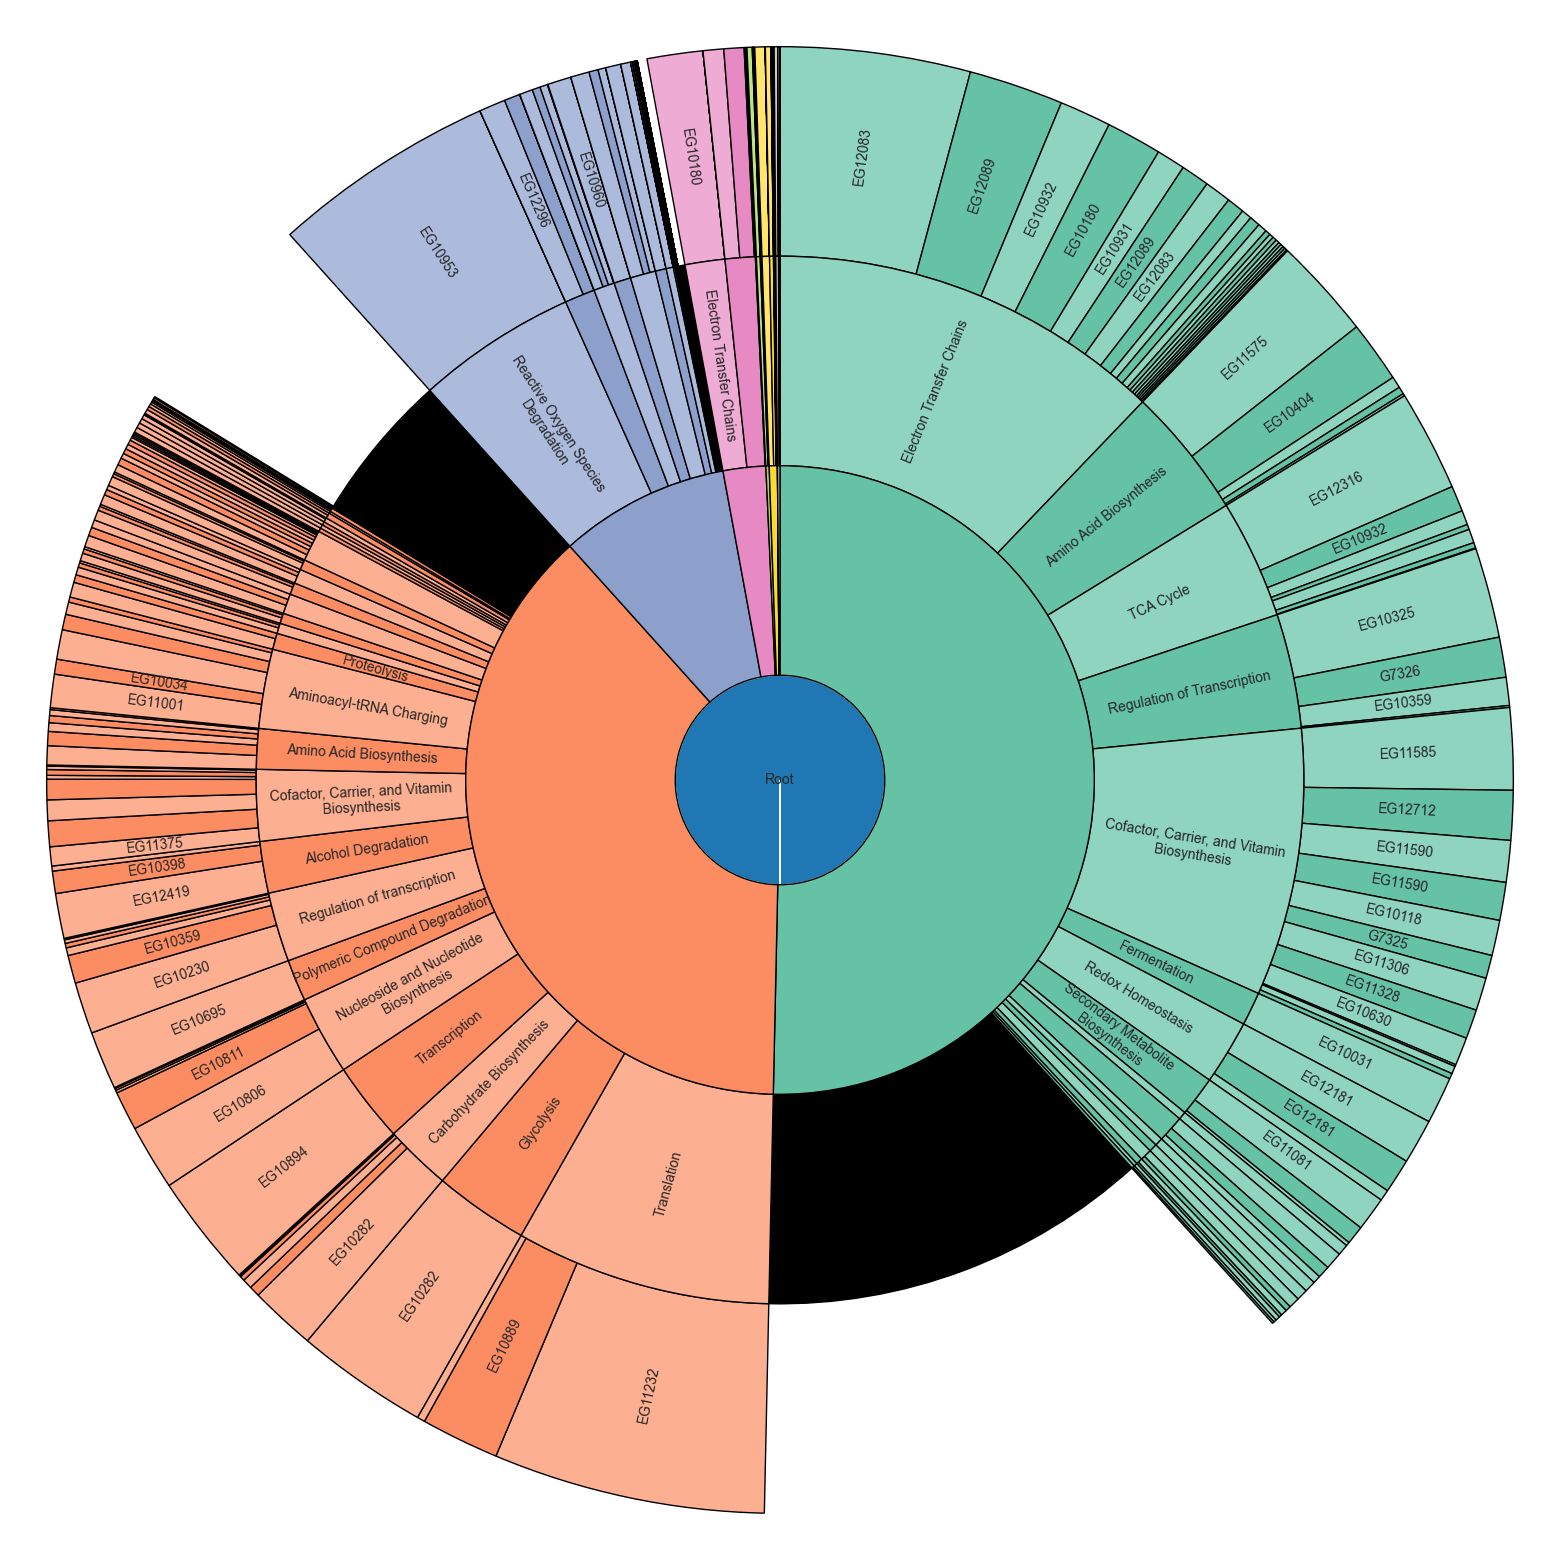

In [41]:
plt.figure(figsize=(20, 20))
sunburst(data_transformed)